单元测试：验证 `plcoding.research.monotone` 模块中的 `MCLIterator` 类是否工作正常，它实现了极化码的高效列表译码，既可以用于单调链极化码，又可以用于经典的极化码

In [1]:
import plcoding
from plcoding.research import monotone
import numpy as np
from tqdm import trange

In [2]:
# 生成一个概率分布
jProb = monotone.JointProb(probs=[0.1286, 0.0175, 0.0175, 0.8364], bases=[2, 2])
#jProb = monotone.JointProb(probs=[0.11, 0.89], bases=[2])
# 初始化一个极化变换上的列表迭代器对象
pIter = monotone.MCLIterator(block_len=(1 << 10), jProb=jProb, list_size=4)
pIter.set_priors(jProb.gen_iids(pIter.N))
# 生成一条单调链
superscripts = np.tile(np.arange(jProb.M), (pIter.N, 1)).T.ravel()
#np.random.shuffle(superscripts)
chain = monotone.MNChain(sups=superscripts, M=jProb.M, N=pIter.N)

我们要绘制译码的BLER-Rate曲线，但不同于经典极化码的是，单调链极化码处理多个信源，每个信源都有一个对应的码率，所以我们这里采用一个技巧，将它们的码率等比例增加，对应的曲线横轴含义为和速率Sum-Rate

In [3]:
# 获取两个信源的信息分配比例（单位比特）
Hs = chain.polarize(jProb, _nsim=100)
ratio = Hs.mean(axis=1)
ratio /= ratio.sum()
# 从理论界开始，逐渐增加比特，并按照比例进行分配
test_rates = np.arange(start=1, stop=2, step=0.1) * jProb.joint_entropy()
test_blers = np.zeros_like(test_rates)

In [4]:
# 对每个测试码率，仿真多轮
for r in trange(len(test_rates), ncols=80):
    # 先针对当前测试码率，生成对应的冻结集
    test_L = np.array(test_rates[r] * ratio / np.array([np.log2(q) for q in jProb.bases]) * pIter.N, dtype=int)
    frozen = np.empty_like(Hs, dtype=bool)
    for var in range(jProb.M):
        frozen[var, :] = plcoding.topk_indicate(Hs[var, :], test_L[var])
    # 然后仿真多轮
    nsim = 100
    for s in range(nsim):
        # 随机生成码字
        x = np.random.choice(a=jProb.size, p=jProb.probs, size=(pIter.N,))
        xs = pIter.split_on(x)
        us = pIter.transform(xs)
        # 译码开始
        pIter.reset()
        for t in range(len(chain)):
            var, index = chain.sups[t], chain.subs[t]
            if frozen[var, index]:
                pIter.freeze_with(var, index, us[var, index])
            else:
                pIter.explore_at(var, index)
        # 译码结束，检查BLER
        results = pIter.final_list()
        llhs = pIter.final_llhs()
        test_blers[r] += (results[np.argmax(llhs)] != xs).any() / nsim

100%|███████████████████████████████████████████| 10/10 [01:58<00:00, 11.80s/it]


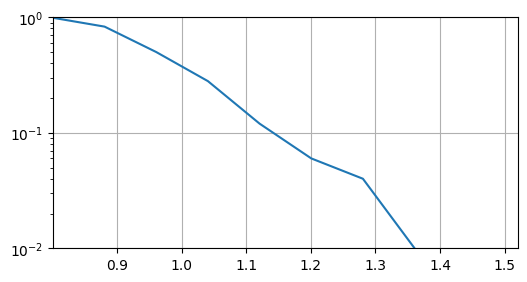

In [5]:
# 绘制BLER-Rate曲线
from matplotlib import pyplot as plt
plt.figure(figsize=[6, 3])
plt.semilogy(test_rates, test_blers)
plt.axis([np.min(test_rates), np.max(test_rates), 1.0 / nsim, 1.0])
plt.grid(); plt.show()